<a href="https://colab.research.google.com/github/the-cafehopper/Research/blob/main/Indonesia_E_Commerce_Energy_202510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy statsmodels pyjanitor openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 5.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
# Paths
household_fp = "dehs2020_household_v2.csv"
individual_fp = "dehs2020_individual_v2.csv"
out_fp = "dehs2020_masterdataset.csv"

In [4]:
# Load
hh = pd.read_csv(household_fp, low_memory=False)
ind = pd.read_csv(individual_fp, low_memory=False)

In [5]:
# Detect merge key (defaults to hhid if present)
hh_cols_lower = {c.lower(): c for c in hh.columns}
ind_cols_lower = {c.lower(): c for c in ind.columns}

if "hhid" in hh_cols_lower and "hhid" in ind_cols_lower:
  hh_key, ind_key = hh_cols_lower["hhid"], ind_cols_lower["hhid"]
else:
  common = set(hh_cols_lower).intersection(ind_cols_lower)
  # heuristic fallback
  candidates = [c for c in common if "hh" in c or "house" in c or c.endswith("id")]
  if not candidates:
    raise ValueError("Could not auto-detect a common household key. Set hh_key and ind_key manually.")
  pick = candidates[0]
  hh_key, ind_key = hh_cols_lower[pick], ind_cols_lower[pick]

In [6]:
# Select + rename household vars
var_map_hh = {
    "m1_iii_1" : "province_code", # province identifier
    "m1_iii_5" : "urban_rural", # 1=Urban, 2=Rural
    "m9_ii_21_ax" : "monthly_income", # income proxy
    "m9_iii_67e" : "digital_payment_raw", # 1 yes, 3 no
    "m9_iii_42" : "ecommerce_raw", # Likert 1..5 (1-2 positive)
    "m1_vi_35" : "lighting_source" # 1 PLN, 2 Non-PLN
}
present_hh = {k: v for k, v in var_map_hh.items() if k in hh.columns}
hh_sub = hh[[hh_key] + list(present_hh.keys())].rename(columns=present_hh)
hh_sub = hh_sub.rename(columns={hh_key: "hhid_key"})

In [7]:
# Recode helpers
def yesno(series, yes=(1,), no=(3,)):
  return series.apply(lambda x: 1 if x in yes else (0 if x in no else np.nan))

# Digital payment (1=yes, 3=no)
if "digital_payment_raw" in hh_sub:
  hh_sub["digital_payment"] = yesno(hh_sub["digital_payment_raw"], yes=(1,), no=(3,))

# E-commerce (Likert 1..5 -> engaged=1 if 1 or 2; else 0
if "ecommerce_raw" in hh_sub:
  hh_sub["ecommerce_participation"] = hh_sub["ecommerce_raw"].apply(
      lambda x: 1 if x in [1,2] else (0 if x in [3,4,5] else np.nan)
  )

# Renewable proxy (Non-PLN -> 1; PLN -> 0)
if "lighting_source" in hh_sub:
  hh_sub["renewable_use"] = hh_sub["lighting_source"].apply(
      lambda x: 1 if x == 2 else (0 if x == 1 else np.nan)
  )

# Urban dummy
if "urban_rural" in hh_sub:
  hh_sub["urban_dummy"] = hh_sub["urban_rural"].apply(
      lambda x: 1 if x == 1 else (0 if x == 2 else np.nan)
  )

# Log income (avoid log(0))
if "monthly_income" in hh_sub:
  hh_sub["log_income"] = np.log(hh_sub["monthly_income"].replace({0: np.nan}))

# Composite digital participation
digital_cols = [c for c in ["digital_payment", "ecommerce_participation"] if c in hh_sub.columns]
if digital_cols:
  hh_sub["digital_participation"] = hh_sub[digital_cols].max(axis=1, skipna=True)

In [8]:
# Education from individual file
if "m1_v_8" not in ind.columns:
    raise ValueError("Education variable 'm1_v_8' not found in individual data.")

# Rename merge key
ind_tmp = ind.rename(columns={ind_key: "hhid_key"})

# Head’s education (relation == 1)
rel_candidates = [c for c in ind_tmp.columns if c.lower() in {"m1_iv_2", "m1_ii_1", "relation", "rel_head"}]

if rel_candidates and rel_candidates[0] in ind_tmp.columns:
    rel_col = rel_candidates[0]
    # Filter for household head only (relation == 1)
    edu_hh = (
        ind_tmp.loc[ind_tmp[rel_col] == 1, ["hhid_key", "m1_v_8"]]
        .dropna()
        .groupby("hhid_key", as_index=False)["m1_v_8"]
        .first()
        .rename(columns={"m1_v_8": "education_level"})
    )
    print(f"Education aggregated using household head column: {rel_col}")
else:
    # Fallback: take MAX education within HH
    edu_hh = (
        ind_tmp.groupby("hhid_key", as_index=False)["m1_v_8"]
        .max()
        .rename(columns={"m1_v_8": "education_level"})
    )
    print("Education aggregated using MAX education within household (head not detected).")


Education aggregated using MAX education within household (head not detected).


In [9]:
# Merge education into household data
df = hh_sub.merge(edu_hh, on="hhid_key", how="left")
print(df[["hhid_key", "education_level"]].head())

   hhid_key  education_level
0      1103              7.0
1      1203              7.0
2      1105              7.0
3      1102              9.0
4      1205              7.0


In [10]:
# Save the file for analysis
df.to_csv(out_fp, index=False)
print("Saved:", out_fp)
print("Columns:", df.columns.tolist())
print(df.head(3))

Saved: dehs2020_masterdataset.csv
Columns: ['hhid_key', 'province_code', 'urban_rural', 'monthly_income', 'digital_payment_raw', 'ecommerce_raw', 'lighting_source', 'digital_payment', 'ecommerce_participation', 'renewable_use', 'urban_dummy', 'log_income', 'digital_participation', 'education_level']
   hhid_key  province_code  urban_rural  monthly_income  digital_payment_raw  \
0      1103             11            2             1.0                  NaN   
1      1203             11            2             NaN                  NaN   
2      1105             11            2             1.0                  NaN   

   ecommerce_raw  lighting_source  digital_payment  ecommerce_participation  \
0            3.0                1              NaN                      0.0   
1            NaN                1              NaN                      NaN   
2            3.0                1              NaN                      0.0   

   renewable_use  urban_dummy  log_income  digital_participat

In [11]:
# Quick diagnosis and descriptives
df = pd.read_csv("dehs2020_masterdataset.csv")

keep = [c for c in ["renewable_use","digital_payment","ecommerce_participation",
                    "digital_participation","log_income","urban_dummy",
                    "education_level","province_code"] if c in df.columns]
print("Available:", keep)

desc = df[keep].describe().T
desc["mean_pct"] = (desc["mean"]*100).round(2)
print(desc[["count","mean","mean_pct","std","min","max"]])

Available: ['renewable_use', 'digital_payment', 'ecommerce_participation', 'digital_participation', 'log_income', 'urban_dummy', 'education_level', 'province_code']
                          count       mean  mean_pct        std   min  \
renewable_use            3054.0   0.009168      0.92   0.095327   0.0   
digital_payment           191.0   0.115183     11.52   0.320082   0.0   
ecommerce_participation  1542.0   0.123865     12.39   0.329534   0.0   
digital_participation    1542.0   0.123865     12.39   0.329534   0.0   
log_income               1542.0   0.024100      2.41   0.221877   0.0   
urban_dummy              3063.0   0.666993     66.70   0.471366   0.0   
education_level          3047.0   8.442402    844.24   4.183718   1.0   
province_code            3063.0  58.303950   5830.40  24.337492  11.0   

                               max  
renewable_use             1.000000  
digital_payment           1.000000  
ecommerce_participation   1.000000  
digital_participation     1.0

In [12]:
# Baseline models (LPM + penalized logit)
import statsmodels.formula.api as smf
import statsmodels.api as sm

d = pd.read_csv("dehs2020_masterdataset.csv")

# RHS builder
digital_rhs = [c for c in ["digital_payment","ecommerce_participation"] if c in d.columns]
if not digital_rhs and "digital_participation" in d.columns:
  digital_rhs = ["digital_participation"]

controls = [c for c in ["log_income","urban_dummy","education_level","province_code"] if c in d.columns]
rhs = " + ".join(digital_rhs + [c for c in controls if c!="province_code"] + (["C(province_code)"] if "province_code" in controls else []))

dm = d.dropna(subset=["renewable_use"] + digital_rhs + [c for c in controls if c!="province_code"] + (["province_code"] if "province_code" in controls else []))

print("N (analysis sample):", len(dm), "| renewable_use mean:", dm["renewable_use"].mean().round(4))

# LPM (robust SE)
lpm = smf.ols(f"renewable_use ~ {rhs}", data=dm).fit(cov_type="HC1")
print(lpm.summary())

# Penalized logit (L2) to handle rare outcome / separation
# Build design matrices from formula (evaluate once)
logit_model = smf.logit(f"renewable_use ~ {rhs}", data=dm)
y, X = logit_model.endog, sm.add_constant(logit_model.exog, has_constant='add')

# L2 penalty via fit_regularized (alpha is penalty strength; tune 0.1-5.0)
logit_pen = sm.Logit(y, X).fit_regularized(alpha=1.0, L1_wt=0.0, maxiter=200)
print("\nPenalized logit coefficients:\n", pd.Series(logit_pen.params, index=["const"]+logit_model.exog_names))

# Clustered SE for LPM by province
if "province_code" in dm.columns:
  lpm_cl = smf.ols(f"renewable_use ~ {rhs}", data=dm).fit(
      cov_type="cluster", cov_kwds={"groups": dm["province_code"]}
  )
  print("\nLPM with province-clustered SE:\n", lpm_cl.summary())

N (analysis sample): 191 | renewable_use mean: 0.0
                            OLS Regression Results                            
Dep. Variable:          renewable_use   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 19 Oct 2025   Prob (F-statistic):                nan
Time:                        14:51:43   Log-Likelihood:                    inf
No. Observations:                 191   AIC:                              -inf
Df Residuals:                     161   BIC:                              -inf
Df Model:                          29                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00935982213840737
            Iterations: 16
            Function evaluations: 18
            Gradient evaluations: 16

Penalized logit coefficients:
 const                      0.000000
Intercept                  0.000000
C(province_code)[T.12]     0.000000
C(province_code)[T.13]     0.000000
C(province_code)[T.15]     0.000000
C(province_code)[T.16]     0.000000
C(province_code)[T.17]     0.000000
C(province_code)[T.18]     0.000000
C(province_code)[T.19]     0.000000
C(province_code)[T.31]     0.000000
C(province_code)[T.32]     0.000000
C(province_code)[T.33]     0.000000
C(province_code)[T.35]     0.000000
C(province_code)[T.36]     0.000000
C(province_code)[T.52]     0.000000
C(province_code)[T.53]     0.000000
C(province_code)[T.61]     0.000000
C(province_code)[T.62]     0.000000
C(province_code)[T.63]     0.000000
C(province_code)[T.64]     0.000000
C(province_code)[T.71]     0.000000
C

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


In [13]:
# heterogeneity (income or rural)
# Interactions
if set(["log_income","digital_participation"]).issubset(dm.columns):
  lpm_int = smf.ols("renewable_use ~ digital_participation*log_income + urban_dummy + education_level + C(province_code)", data=dm).fit(cov_type="HC1")
  print(lpm_int.summary())

# Rural only
if "urban_dummy" in dm.columns:
  dm_rural = dm[dm["urban_dummy"]==0].copy()
  if len(dm_rural) >50:
    lpm_rural = smf.ols(f"renewable_use ~ {rhs}", data=dm_rural).fit(cov_type="HC1")
    print("\nRural only LPM:\n", lpm_rural.summary())

                            OLS Regression Results                            
Dep. Variable:          renewable_use   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 19 Oct 2025   Prob (F-statistic):                nan
Time:                        14:51:44   Log-Likelihood:                    inf
No. Observations:                 191   AIC:                              -inf
Df Residuals:                     162   BIC:                              -inf
Df Model:                          28                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


In [14]:
# Export clean tables (for markdown)
def simple_table(result, title="Table", roundto=3):
  coefs = result.params.round(roundto)
  ses = result.bse.round(roundto) if hasattr(result, "bse") else None
  rows = []
  for name in coefs.index:
    if name == "intercept" or name == "const":
      label = "Constant"
    else:
      label = name
    if ses is not None and name in ses.index:
      rows.append(f"| {label} | {coefs[name]} | |")
  header = f"### {title}\n\n| Variable | Coef. | SE |\n|---|---:|---:|\n"
  return header + "\n".join(rows)

print(simple_table(lpm, "Baseline LPM (HC1)"))
if "lpm_cl" in locals():
    print(simple_table(lpm_cl, "Baseline LPM (Province-clustered)"))

### Baseline LPM (HC1)

| Variable | Coef. | SE |
|---|---:|---:|
| Intercept | 0.0 | |
| C(province_code)[T.12] | 0.0 | |
| C(province_code)[T.13] | 0.0 | |
| C(province_code)[T.15] | 0.0 | |
| C(province_code)[T.16] | 0.0 | |
| C(province_code)[T.17] | 0.0 | |
| C(province_code)[T.18] | 0.0 | |
| C(province_code)[T.19] | 0.0 | |
| C(province_code)[T.31] | 0.0 | |
| C(province_code)[T.32] | 0.0 | |
| C(province_code)[T.33] | 0.0 | |
| C(province_code)[T.35] | 0.0 | |
| C(province_code)[T.36] | 0.0 | |
| C(province_code)[T.52] | 0.0 | |
| C(province_code)[T.53] | 0.0 | |
| C(province_code)[T.61] | 0.0 | |
| C(province_code)[T.62] | 0.0 | |
| C(province_code)[T.63] | 0.0 | |
| C(province_code)[T.64] | 0.0 | |
| C(province_code)[T.71] | 0.0 | |
| C(province_code)[T.72] | 0.0 | |
| C(province_code)[T.73] | 0.0 | |
| C(province_code)[T.74] | 0.0 | |
| C(province_code)[T.81] | 0.0 | |
| C(province_code)[T.91] | 0.0 | |
| C(province_code)[T.94] | 0.0 | |
| digital_payment | 0.0 | |
| ecommer

In [15]:
# Regression troubleshooting
# Dependent variable (renewable_use) has no variation and the regression couldnt estimate anything meaningful
# Check if renewable_use actually varies
dm["renewable_use"].value_counts(dropna=False)

,count
renewable_use,
0.0,191


In [16]:
# Every observation is non-renewable ir. renewable_use = 0 for all households
# Investigate raw variable
print(hh["m1_vi_35"].value_counts(dropna=False))

m1_vi_35
1    3026
2      28
3       9
Name: count, dtype: int64


In [17]:
# Seems like when the dataset was merged and cleanred, the regression sample (dm) dropped all the 2s and 3s so the regression coefficients are all 0
# Confrim which households were dropped
print(hh_sub["renewable_use"].value_counts(dropna=False))
print(d["renewable_use"].value_counts(dropna=False))
print(dm["renewable_use"].value_counts(dropna=False))

renewable_use
0.0    3026
1.0      28
NaN       9
Name: count, dtype: int64
renewable_use
0.0    3026
1.0      28
NaN       9
Name: count, dtype: int64
renewable_use
0.0    191
Name: count, dtype: int64


In [18]:
# Adjust the dependent variable definition
# Recode the renewable variable more inclusively: 1=PLN(on-grid), 2=Non-PLN(off-grid), 3=PLN+Non-PLN(hybrid)
hh_sub["renewable_use"] = hh_sub["lighting_source"].map({1: 0, 2: 1, 3: 1})

hh_sub["renewable_use"].value_counts(dropna=False)

,count
renewable_use,
0,3026
1,37


In [19]:
# Re-merge and re-run regression
df = hh_sub.merge(edu_hh, on="hhid_key", how="left")
df.to_csv("dehs2020_masterdataset.csv", index=False)

# Same LPM model code as before
lpm = smf.ols(f"renewable_use ~ {rhs}", data=df).fit(cov_type="HC1")
print(lpm.summary())

                            OLS Regression Results                            
Dep. Variable:          renewable_use   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 19 Oct 2025   Prob (F-statistic):                nan
Time:                        14:51:44   Log-Likelihood:                    inf
No. Observations:                 191   AIC:                              -inf
Df Residuals:                     161   BIC:                              -inf
Df Model:                          29                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


In [20]:
# The regression is still collapsing even though m1_vi_35 has been recoded to include 2 and 3 as renewable; the regression sample (dm, 191 obs) still contains only 0s
# Quick diagnostic
# Check overall dataset before filtering
print(df["renewable_use"].value_counts(dropna=False))

# Check modeling sample after dropna
print(dm["renewable_use"].value_counts(dropna=False))

# See what rows got dropped
print(len(df), "total rows in df")
print(len(dm), "rows used in regression")

renewable_use
0    3026
1      37
Name: count, dtype: int64
renewable_use
0.0    191
Name: count, dtype: int64
3063 total rows in df
191 rows used in regression


In [21]:
# Relax the filtering so it only require renewable_use to be nonmissing
# Keep all renewable households
# Rebuild the model dataset, keeping renewable_use nonmissing
needed = ["renewable_use"] + digital_rhs + controls
if "province_code" in d.columns and "province_code" not in needed:
  needed.append("province_code")

dm = d[needed].copy()
dm = dm.dropna(subset=["renewable_use"])

print("After relaxed filtering:")
print(dm["renewable_use"].value_counts(dropna=False))

After relaxed filtering:
renewable_use
0.0    3026
1.0      28
Name: count, dtype: int64


In [22]:
# Recreate digital_participation
# Build from available digital flags
cand = [c for c in ["digital_payment","ecommerce_participation"] if c in dm.columns]
if "digital_participation" not in dm.columns and cand:
  dm["digital_participation"] = dm[cand].max(axis=1, skipna=True)

# If neither digital var exists, stop and show whats missing
if not [c for c in ["digital_participation","digital_payment","ecommerce_participation"] if c in dm.columns]:
  raise ValueError("No digital variables present. Ensure digital_payment / ecommerce_participation were created earlier.")

# Make sure key variables are numeric
to_num = [c for c in ["renewable_use","digital_participation","digital_payment",
                      "ecommerce_participation","log_income","urban_dummy",
                      "education_level"] if c in dm.columns]
for c in to_num:
  dm[c] = pd.to_numeric(dm[c], errors="coerce")

# Build a simple RHS that adapts to whats present
digital_rhs = [c for c in ["digital_participation","digital_payment","ecommerce_participation"] if c in dm.columns]
controls = [c for c in ["log_income","urban_dummy","education_level"] if c in dm.columns]
rhs = " + ".join(digital_rhs + controls)

# Keep rows with DV and at least the RHS being used
d_run = dm.dropna(subset=["renewable_use"] + digital_rhs + controls)
print("N used:", len(d_run))
print("Renewable use distribution:\n", d_run["renewable_use"].value_counts(dropna=False))

N used: 191
Renewable use distribution:
 renewable_use
0.0    191
Name: count, dtype: int64


In [23]:
# Run a simpler model: no province FE yet
lpm_simple = smf.ols(f"renewable_use ~ {rhs}", data=d_run).fit(cov_type="HC1")
print(lpm_simple.summary())

                            OLS Regression Results                            
Dep. Variable:          renewable_use   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 19 Oct 2025   Prob (F-statistic):                nan
Time:                        14:51:44   Log-Likelihood:                    inf
No. Observations:                 191   AIC:                              -inf
Df Residuals:                     186   BIC:                              -inf
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


In [24]:
# The regression result still shows all 0s; may be because an older filtered subset (dm) from before relaxing the filtering is being used
# Recreate a flesh dataset for modeling
# Rebuild a clean version from the full df (2026 + 28 households)
dm = df.copy()
cols = ["renewable_use", "digital_participation","log_income","urban_dummy","education_level"]
dm = dm[cols].dropna(subset=["renewable_use"])
print("Fresh sample size:", len(dm))

Fresh sample size: 3063


In [25]:
# Rerun the same regression model
# Run the baseline regression
lpm_simple = smf.ols(
    "renewable_use ~ digital_participation + log_income + urban_dummy + education_level",
    data=dm
).fit(cov_type="HC1")

print(lpm_simple.summary())

                            OLS Regression Results                            
Dep. Variable:          renewable_use   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.387
Date:                Sun, 19 Oct 2025   Prob (F-statistic):            0.00157
Time:                        14:51:45   Log-Likelihood:                 1305.3
No. Observations:                1536   AIC:                            -2601.
Df Residuals:                    1531   BIC:                            -2574.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.03

In [26]:
# Further issues inspection and fix
# See which variables are causing the drop
# Runt a diagnostic
missing_summary = dm.isna().sum()
print(missing_summary)

renewable_use               0
digital_participation    1521
log_income               1521
urban_dummy                 0
education_level            16
dtype: int64


In [27]:
# Check whether nearly all the rows have NaN in at least one of those columns
dm_clean = dm.dropna(subset=["renewable_use","digital_participation","log_income","urban_dummy","education_level"])
print("Rows remaining after full non-missing filter:", len(dm_clean))

Rows remaining after full non-missing filter: 1536


In [28]:
# Inspect why the NaNs exist
for col in ["digital_participation","log_income","urban_dummy","education_level"]:
  print(col, dm[col].unique()[:10])

digital_participation [ 0. nan  1.]
log_income [0.                nan 2.07944154 1.94591015]
urban_dummy [0 1]
education_level [ 7.  9. 13.  2.  4. 11. 12.  8.  1. 14.]


In [29]:
# Quick patch: recode missing data for now
dm_test = dm.fillna({
    "digital_participation": 0,
    "digital_payment": 0,
    "ecommerce_participation": 0,
    "log_income": dm["log_income"].median(),
    "urban_dummy": dm["urban_dummy"].mode()[0],
    "education_level": dm["education_level"].median()
})

In [30]:
# Rerun the model
# This is the final version of the regression model
lpm_simple = smf.ols(
    "renewable_use ~ digital_participation + log_income + urban_dummy + education_level",
    data=dm_test
).fit(cov_type="HC1")

print(lpm_simple.summary())

                            OLS Regression Results                            
Dep. Variable:          renewable_use   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.859
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           4.14e-07
Time:                        14:51:45   Log-Likelihood:                 2460.8
No. Observations:                3063   AIC:                            -4912.
Df Residuals:                    3058   BIC:                            -4881.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.03

In [31]:
# Create a descriptive statistics table
# Import libraries
import pandas as pd

# Define the descriptive stats dataframe
cols = [
    "renewable_use", # 1 if uses renewables
    "digital_payment", # 1 if uses digital payment
    "ecommerce_participation", # 1 if uses ecommerce
    "digital_participation", # 1 if uses solar/renewable energy
    "log_income", # log of income
    "urban_dummy", # 1 if urban
    "education_level", # years of schooling of household head
    "province_code"
]
desc = df[cols].describe().T.rename(columns={
     "count": "Obs",
    "mean": "Mean",
    "std": "Std. Dev.",
    "min": "Min",
    "max": "Max"
})[["Obs", "Mean", "Std. Dev.", "Min", "Max"]]

# Round numeric values to 3 decimal places
desc = desc.round(3)

# Define the grounps and the rows that belong to each group
groups = {
    "Dependent variable": ["renewable_use"],
    "Independent variables": ["digital_payment", "ecommerce_participation", "digital_participation"],
    "Control variables": ["log_income", "urban_dummy", "education_level", "province_code"],
}

# Assemble the final table with header rows inserted
parts = []
for header, var_list in groups.items():
    header_row = pd.DataFrame([[None]*5], columns=["Obs","Mean","Std. Dev.","Min","Max"], index=[header])
    parts.append(header_row)
    parts.append(desc.loc[var_list])

desc_ordered = pd.concat(parts, axis=0, ignore_index=False).fillna("") # blanks for header rows

# Display with bold headers
header_names = set(groups.keys())
styler = (
    desc_ordered.style
    .format(precision=3)
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "left"), ("font-weight", "normal")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    .apply(lambda s: ["font-weight: bold: text-align:left" if s.name in header_names else "" for _ in s], axis=1)
)
styler


/tmp/ipython-input-990507258.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  desc_ordered = pd.concat(parts, axis=0, ignore_index=False).fillna("") # blanks for header rows


,Obs,Mean,Std. Dev.,Min,Max
Dependent variable,,,,,
renewable_use,3063.000,0.012,0.109,0.000,1.000
Independent variables,,,,,
digital_payment,191.000,0.115,0.320,0.000,1.000
ecommerce_participation,1542.000,0.124,0.330,0.000,1.000
digital_participation,1542.000,0.124,0.330,0.000,1.000
Control variables,,,,,
log_income,1542.000,0.024,0.222,0.000,2.079
urban_dummy,3063.000,0.667,0.471,0.000,1.000
education_level,3047.000,8.442,4.184,1.000,99.000


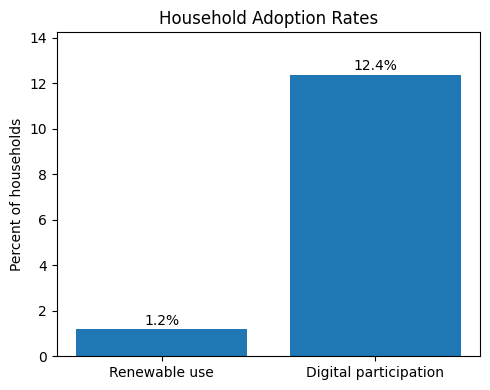

In [33]:
# Visualize a bar chart for renewbales vs. digital participation
# Settings
DATA_FP = "/content/dehs2020_masterdataset.csv"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(DATA_FP)

# Compute rates (ignore NaNs)
rates = (
    df[['renewable_use', 'digital_participation']]
    .mean(numeric_only=True)
    .mul(100)
    .rename({'renewable_use':'Renewable use', 'digital_participation':'Digital participation'})
)

# Simple bar chart
plt.figure(figsize=(5,4))
bars = plt.bar(rates.index, rates.values)
plt.title("Household Adoption Rates")
plt.ylabel("Percent of households")
plt.ylim(0, max(2.5, rates.max()*1.15)) # keep y-axis sensible when reneewables are ~1%
# Annotate bars
for b in bars:
  plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.05, f"{b.get_height():.1f}%", ha='center', va='bottom')
  plt.tight_layout()
  plt.savefig("bar_twin_transitions.png", dpi=300)
plt.show()

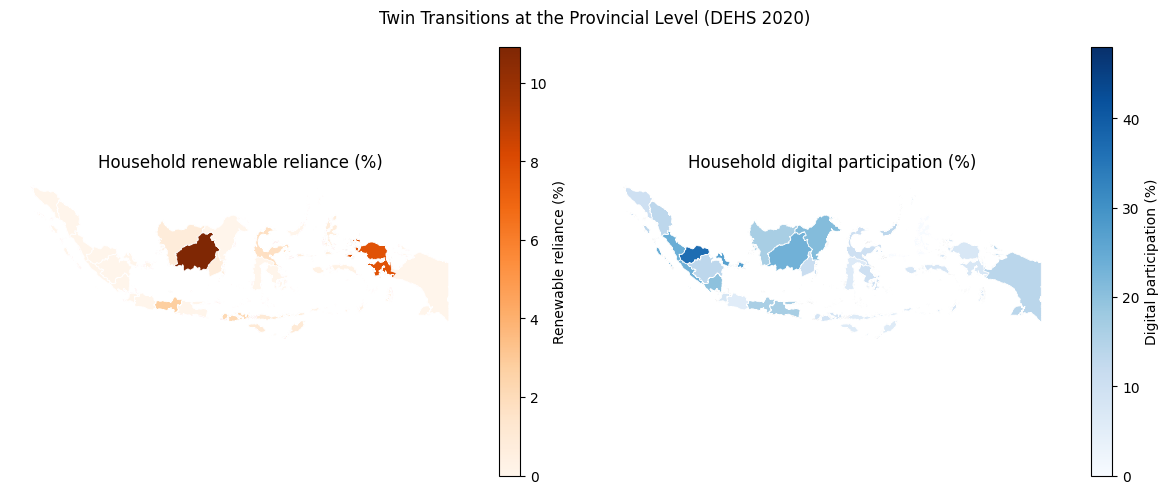

Unmatched (if any)
Empty DataFrame
Columns: [province_code, NAME_1]
Index: []


In [65]:
# Visualize province maps (GADM level-1)
# Setting with GeoJSON path
GADM_FP = "/content/gadm41_IDN_1.json"

# Import geopandas
import geopandas as gdp
import matplotlib.pyplot as plt

# Load data and summarize by province
df = pd.read_csv(DATA_FP)

prov_summary = (
    df.groupby('province_code', dropna=True)
    .agg(renewable_rate=('renewable_use','mean'),
         digital_rate=('digital_participation','mean'))
    .reset_index()
)

# Convert to percentages
prov_summary['renewable_rate'] = prov_summary['renewable_rate'] * 100
prov_summary['digital_rate'] = prov_summary['digital_rate'] * 100

# Load GADM Level-1
try:
  idn = gdp.read_file(GADM_FP) # GeoJSON
except Exception:
  # Fallback if gdp.read_file fails, assuming 'idn' was loaded elsewhere (though this should not happen with the import fix)
  # If 'idn' is truly not defined after the import, there's a bigger issue, but for now,
  # retain this fallback with the corrected variable name in the slice.
  if 'idn' in locals():
      idn = idn[['GID_1', 'NAME_1', 'geometry']].copy()
  else:
      raise # Re-raise if idn is still not defined


# Map BPS numeric codes -> GADM NAME_1 (handles DKI/DIY names and the Kepulauan/Kab. variations)
bps_to_name = {
    11: "Aceh",
    12: "SumateraUtara", # Corrected mapping
    13: "SumateraBarat", # Corrected mapping
    14: "Riau",
    15: "Jambi",
    16: "SumateraSelatan", # Corrected mapping
    17: "Bengkulu",
    18: "Lampung",
    19: "BangkaBelitung", # Corrected mapping
    21: "KepulauanRiau", # Corrected mapping
    31: "JakartaRaya", # Corrected mapping
    32: "JawaBarat", # Corrected mapping
    33: "JawaTengah", # Corrected mapping
    34: "Yogyakarta", # Corrected mapping
    35: "JawaTimur", # Corrected mapping
    36: "Banten",
    51: "Bali",
    52: "NusaTenggaraBarat", # Corrected mapping
    53: "NusaTenggaraTimur", # Corrected mapping
    61: "KalimantanBarat", # Corrected mapping
    62: "KalimantanTengah", # Corrected mapping
    63: "KalimantanSelatan", # Corrected mapping
    64: "KalimantanTimur", # Corrected mapping
    65: "KalimantanUtara", # Corrected mapping
    71: "SulawesiUtara", # Corrected mapping
    72: "SulawesiTengah", # Corrected mapping
    73: "SulawesiSelatan", # Corrected mapping
    74: "SulawesiTenggara", # Corrected mapping
    75: "Gorontalo",
    76: "SulawesiBarat", # Corrected mapping
    81: "Maluku",
    82: "MalukuUtara", # Corrected mapping
    91: "Papua",
    94: "PapuaBarat", # Corrected mapping
}

prov_summary['NAME_1'] = prov_summary['province_code'].map(bps_to_name)

# Normalize names (handles minor label differences and match GASM)
def norm(x):
    return str(x).replace("Daerah Istimewa Yogyakarta", "DI Yogyakarta")\
                  .replace("DKI Jakarta", "DKI Jakarta")\
                  .replace("Kep. Bangka Belitung","Kepulauan Bangka Belitung")\
                  .strip().lower()

prov_summary['name_key'] = prov_summary['NAME_1'].apply(norm)
idn['name_key'] = idn['NAME_1'].apply(norm)

# Merge and plot
gdf = idn.merge(prov_summary, on='name_key', how='left')

fig, axes = plt.subplots(1, 2, figsize=(12,5))
gdf.plot(
    column='renewable_rate', cmap='Oranges', linewidth=0.5, edgecolor='white',
    legend=True, legend_kwds={'label':"Renewable reliance (%)"}, ax=axes[0]
)
axes[0].set_title("Household renewable reliance (%)")
axes[0].axis('off')

gdf.plot(
    column='digital_rate', cmap='Blues', linewidth=0.5, edgecolor='white',
    legend=True, legend_kwds={'label':"Digital participation (%)"}, ax=axes[1]
)
axes[1].set_title("Household digital participation (%)")
axes[1].axis('off')

plt.suptitle("Twin Transitions at the Provincial Level (DEHS 2020)", y=0.98)
plt.tight_layout()
plt.show()

# Quick check for any unmacthed provinces
missing = prov_summary.loc[~prov_summary['name_key'].isin(idn['name_key'])]
print("Unmatched (if any)")
print(missing[['province_code','NAME_1']])

In [49]:
# Troubleshooting for the above mapping visualization missing data issues - for work
print("Unmatched provinces from survey data:")
print(missing[['province_code','NAME_1']])

print("\nUnique province names in geographic data:")
print(idn['NAME_1'].unique())

Unmatched provinces from survey data:
Empty DataFrame
Columns: [province_code, NAME_1]
Index: []

Unique province names in geographic data:
['Aceh' 'Bali' 'BangkaBelitung' 'Banten' 'Bengkulu' 'Gorontalo'
 'JakartaRaya' 'Jambi' 'JawaBarat' 'JawaTengah' 'JawaTimur'
 'KalimantanBarat' 'KalimantanSelatan' 'KalimantanTengah'
 'KalimantanTimur' 'KalimantanUtara' 'KepulauanRiau' 'Lampung' 'Maluku'
 'MalukuUtara' 'NusaTenggaraBarat' 'NusaTenggaraTimur' 'Papua'
 'PapuaBarat' 'Riau' 'SulawesiBarat' 'SulawesiSelatan' 'SulawesiTengah'
 'SulawesiTenggara' 'SulawesiUtara' 'SumateraBarat' 'SumateraSelatan'
 'SumateraUtara' 'Yogyakarta']


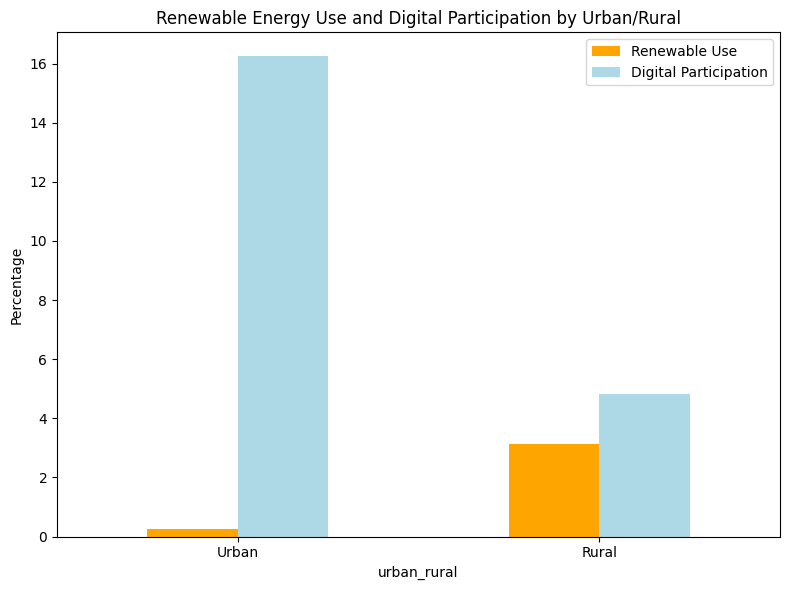

In [64]:
# Visualize renewable energy use and digital participation by urban/rural
# Group by urban_rural and calculate the mean for the two variables
urban_rural_comparison = df.groupby('urban_rural')[['renewable_use', 'digital_participation']].mean() * 100

# Rename index for better readability
urban_rural_comparison = urban_rural_comparison.rename(index={1: 'Urban', 2: 'Rural'})

# Plotting the bar chart
urban_rural_comparison.plot(kind='bar', figsize=(8, 6), color=['orange', 'lightblue'])
plt.title('Renewable Energy Use and Digital Participation by Urban/Rural')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(['Renewable Use', 'Digital Participation'])
plt.tight_layout()
plt.show()

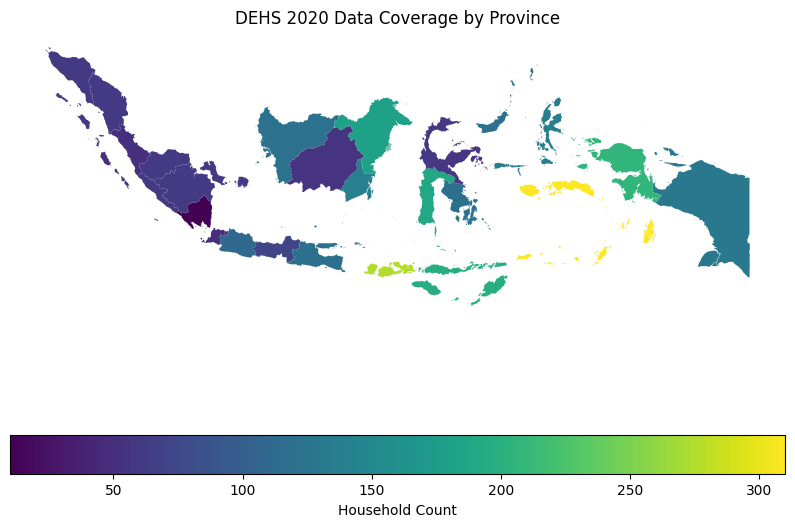

In [58]:
# Visualize Indonesia map showing DEHS 2020 data coverage
# Calculate data coverage by province (number of households)
data_coverage = df['province_code'].value_counts().reset_index()
data_coverage.columns = ['province_code', 'household_count']

# Merge with the geographic data
# Reload idn to ensure having the original with GID_1
GADM_FP = "/content/gadm41_IDN_1.json.zip"
idn = gdp.read_file(GADM_FP) # GeoJSON
# idn['GID_1'] = idn['GID_1'].str.split('.').str[1].astype(int) # Remove this line

# Use the existing mapping and normalization to create a common key
data_coverage['NAME_1'] = data_coverage['province_code'].map(bps_to_name)
data_coverage['name_key'] = data_coverage['NAME_1'].apply(norm)
idn['name_key'] = idn['NAME_1'].apply(norm)


merged_coverage = idn.merge(data_coverage, on="name_key", how="left")

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_coverage.plot(column='household_count', cmap='viridis', legend=True,
                     legend_kwds={'label': "Household Count",
                                  'orientation': "horizontal"}, ax=ax)
ax.set_title("DEHS 2020 Data Coverage by Province")
ax.axis('off')
plt.show()

In [59]:
# Troubleshooting DHES data coverage - for work
print("Data types and unique values in data_coverage['province_code']:")
print(data_coverage['province_code'].dtype)
print(data_coverage['province_code'].unique())

print("\nData types and unique values in idn['GID_1']:")
print(idn['GID_1'].dtype)
print(idn['GID_1'].unique())

Data types and unique values in data_coverage['province_code']:
int64
[81 52 94 53 73 64 63 82 91 61 35 74 71 32 33 11 15 12 19 16 17 72 62 13
 31 36 18]

Data types and unique values in idn['GID_1']:
object
['IDN.1_1' 'IDN.2_1' 'IDN.3_1' 'IDN.4_1' 'IDN.5_1' 'IDN.6_1' 'IDN.7_1'
 'IDN.8_1' 'IDN.9_1' 'IDN.10_1' 'IDN.11_1' 'IDN.12_1' 'IDN.13_1'
 'IDN.14_1' 'IDN.34_1' 'IDN.35_1' 'IDN.16_1' 'IDN.17_1' 'IDN.19_1'
 'IDN.18_1' 'IDN.20_1' 'IDN.21_1' 'IDN.23_1' 'IDN.22_1' 'IDN.24_1'
 'IDN.25_1' 'IDN.26_1' 'IDN.27_1' 'IDN.28_1' 'IDN.29_1' 'IDN.30_1'
 'IDN.31_1' 'IDN.32_1' 'IDN.33_1']
